In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from scipy.stats import iqr
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# for preprocessing the data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# the model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [7]:
train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
# selected_features = ['foundation_type', 
#                      'area_percentage', 
#                      'height_percentage',
#                      'count_floors_pre_eq',
#                      'land_surface_condition',
#                      'has_superstructure_cement_mortar_stone']
# train_values_subset = train_values[selected_features]
train_values_subset = train_values

train_values_subset.columns.__len__()

38

In [3]:
train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


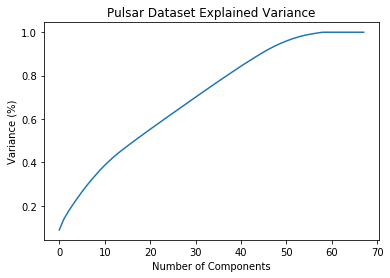

In [4]:
#Decide what n_components for PCA
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(train_values_subset)
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [ ]:
#Train the model
## RBF kernels
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]
pipe = Pipeline(pipe_steps)
param_grid = {'pca__n_components': [90],
              'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 70, 100, 500, 1000],
              'SupVM__gamma': [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50],
             }
print('Start fitting training data')

num_cv = 5
gs = GridSearchCV(pipe, param_grid, cv=num_cv)
gs.fit(train_values_subset, train_labels.values.ravel())
print("Best fit parameter for %d fold CV" % num_cv, gs.best_params_)

#Evaluate the model
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

In [ ]:
#Read values then output Results
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)
predictions = gs.predict(test_values_subset)
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.head()
my_submission.to_csv('submission.csv')